In [74]:
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
from ucimlrepo import fetch_ucirepo
import numpy as np

steel_industry_energy_consumption = fetch_ucirepo(id=851) 
X = steel_industry_energy_consumption.data.features 
y = steel_industry_energy_consumption.data.targets   
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=np.number).columns

In [76]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler

y = LabelEncoder().fit_transform(np.ravel(y))

columnTransformer = ColumnTransformer(
    transformers=[
        ('categorical', TargetEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)]
)
X = columnTransformer.fit_transform(X, y)

In [77]:
from torch.utils.data import Dataset


class MyDataset(Dataset):

    def __init__(self, x, y, q=1):
        self.x = torch.tensor(x, dtype=torch.float32).to(device)
        self.y = torch.tensor(y).long().to(device)
        self.q = q

    def __len__(self):
        return self.x.shape[0] - self.q + 1

    def __getitem__(self, i):
        return self.x[i:i + self.q], self.y[i + self.q - 1]

In [78]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

batch_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

train_loader = DataLoader(MyDataset(X_train, y_train, 5), batch_size = 64, shuffle = False)
test_loader = DataLoader(MyDataset(X_test, y_test, 5), batch_size = 64, shuffle = False)

In [79]:
outFormat = "test_loss: {0[0]}, train_loss: {0[1]}, test_accuracy: {0[2]}, train_accuracy: {0[3]}"


class TrainInfo:
    def __init__(self):
        self.test_loss = []
        self.test_accuracy = []
        self.train_loss = []
        self.train_accuracy = []

    def on_train(self, loss: int, accuracy: int):
        self.train_loss.append(loss)
        self.train_accuracy.append(accuracy)

    def on_test(self, loss: int, accuracy: int):
        self.test_loss.append(loss)
        self.test_accuracy.append(accuracy)

    def paint(self):
        _, v = plt.subplots(1, 2, figsize=(16, 4))
        v[0].plot(range(1, len(self.train_loss) + 1), self.train_loss, label='train')
        v[0].plot(range(1, len(self.test_loss) + 1), self.test_loss, label='test')
        v[0].set_ylabel('loss')
        v[0].set_xlabel('epoch')
        v[0].legend()

        v[1].plot(range(1, len(self.train_accuracy) + 1), self.train_accuracy, label='train')
        v[1].plot(range(1, len(self.test_accuracy) + 1), self.test_accuracy, label='test')
        v[1].set_ylabel('accuracy')
        v[1].set_xlabel('epoch')
        v[1].legend()

        plt.show()

    def result(self) -> tuple[float, float, float, float]:
        return self.test_loss[-1], self.train_loss[-1], self.test_accuracy[-1], self.train_accuracy[-1]

In [84]:
from tqdm.notebook import tqdm
from torch.optim import Optimizer
from torch import nn


def run_model(model: nn.Module, criterion: nn.Module, optimizer: Optimizer, num_epochs: int) -> TrainInfo:
    result = TrainInfo()
    for _ in (pbar := tqdm(range(num_epochs), total=num_epochs)):
        model.train()
        train_loss, train_accuracy = 0, 0
        for features, target in train_loader:
            optimizer.zero_grad()
            output = model(features)
            crit = criterion(output, target)
            crit.backward()
            optimizer.step()
            train_loss += crit.item() * features.size(0)
            train_accuracy += (output.argmax(axis=1) == target).sum().item()
        result.on_train(train_loss / len(train_loader.dataset), train_accuracy / len(train_loader.dataset))
        model.eval()
        test_loss, test_accuracy = 0, 0
        for features, target in test_loader:
            output = model(features)
            crit = criterion(output, target)
            test_loss += crit.item() * features.size(0)
            test_accuracy += (output.argmax(axis=1) == target).sum().item()
        result.on_test(test_loss / len(test_loader.dataset), test_accuracy / len(test_loader.dataset))
        pbar.set_postfix({
            'train loss': train_loss / len(train_loader.dataset), 
            'test loss': test_loss / len(test_loader.dataset), 
            'train accuracy' : train_accuracy / len(train_loader.dataset), 
            'test accuracy' : test_accuracy / len(test_loader.dataset)
        })
    return result

In [81]:
class RNN(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.RNN(input_size=in_features, hidden_size=hidden_size, batch_first=True,
                              nonlinearity='relu')
        self.head = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, out = self.encoder(x)
        return self.head(out[-1])

In [85]:
rnnModel = RNN(
    in_features=next(iter(train_loader))[0].size(2),
    num_classes=next(iter(test_loader))[0].size(1),
    hidden_size=32
).to(device)
rnnResult = run_model(
    model=rnnModel,
    optimizer=torch.optim.SGD(rnnModel.parameters(), lr=0.01, momentum=0.9),
    criterion=nn.CrossEntropyLoss(),
    num_epochs=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

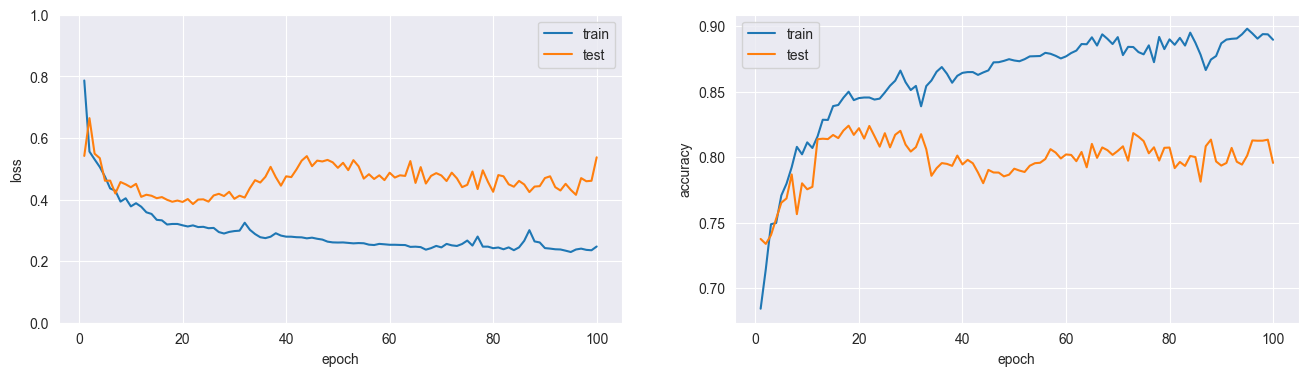

test_loss: 0.5370545973604873, train_loss: 0.24747395893776317, test_accuracy: 0.795561581275867, train_accuracy: 0.8896344945745288


In [87]:
rnnResult.paint()
print(outFormat.format(rnnResult.result()))

In [88]:
class LSTM(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size = in_features, hidden_size = hidden_size, batch_first = True)
        self.head = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        hn, cn = out
        return self.head(hn[-1])

In [89]:
lstmModel = LSTM(
    in_features=next(iter(train_loader))[0].size(2),
    num_classes=next(iter(test_loader))[0].size(1),
    hidden_size=32
).to(device)
lstmResult = run_model(
    model=lstmModel,
    optimizer=torch.optim.SGD(lstmModel.parameters(), lr=0.01, momentum=0.9),
    criterion=nn.CrossEntropyLoss(),
    num_epochs=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

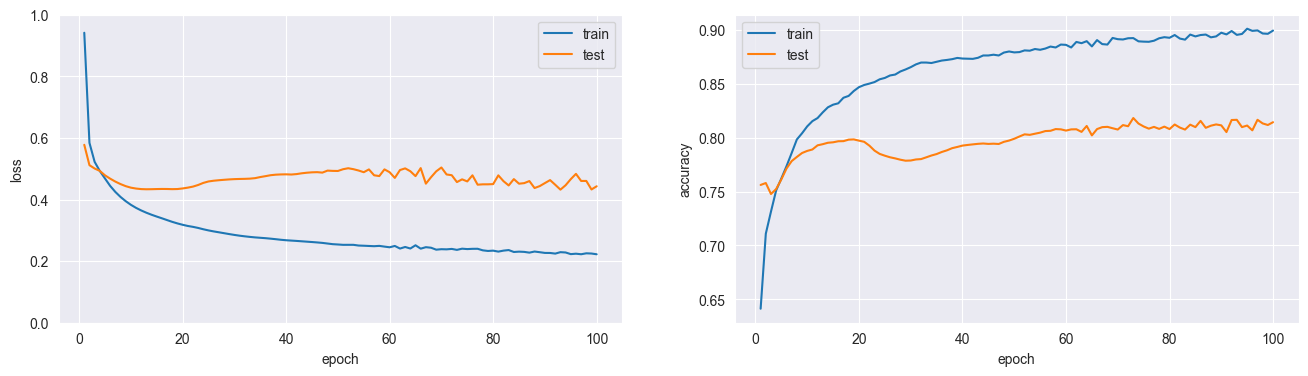

test_loss: 0.44302874147643184, train_loss: 0.22222967619349757, test_accuracy: 0.8143998858284572, train_accuracy: 0.8994860079954312


In [90]:
lstmResult.paint()
print(outFormat.format(lstmResult.result()))

In [91]:
class GRU(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.GRU(input_size = in_features, hidden_size = hidden_size, batch_first = True)
        self.head = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        return self.head(out[-1])

In [92]:
gruModel = GRU(
    in_features=next(iter(train_loader))[0].size(2),
    num_classes=next(iter(test_loader))[0].size(1),
    hidden_size=32
).to(device)
gruResult = run_model(
    model=gruModel,
    optimizer=torch.optim.SGD(gruModel.parameters(), lr=0.01, momentum=0.9),
    criterion=nn.CrossEntropyLoss(),
    num_epochs=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

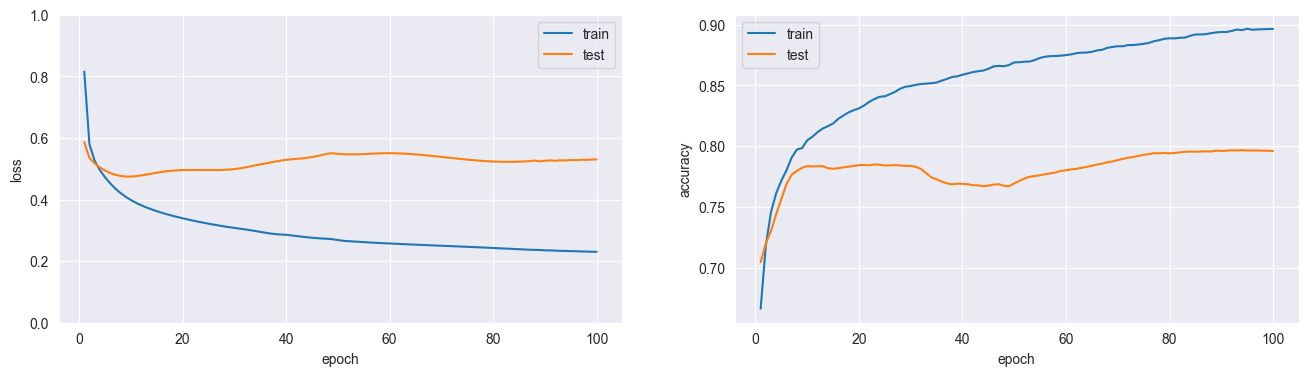

test_loss: 0.530090160126541, train_loss: 0.2302294047469585, test_accuracy: 0.7960967603824747, train_accuracy: 0.8964877213021131


In [93]:
gruResult.paint()
print(outFormat.format(gruResult.result()))

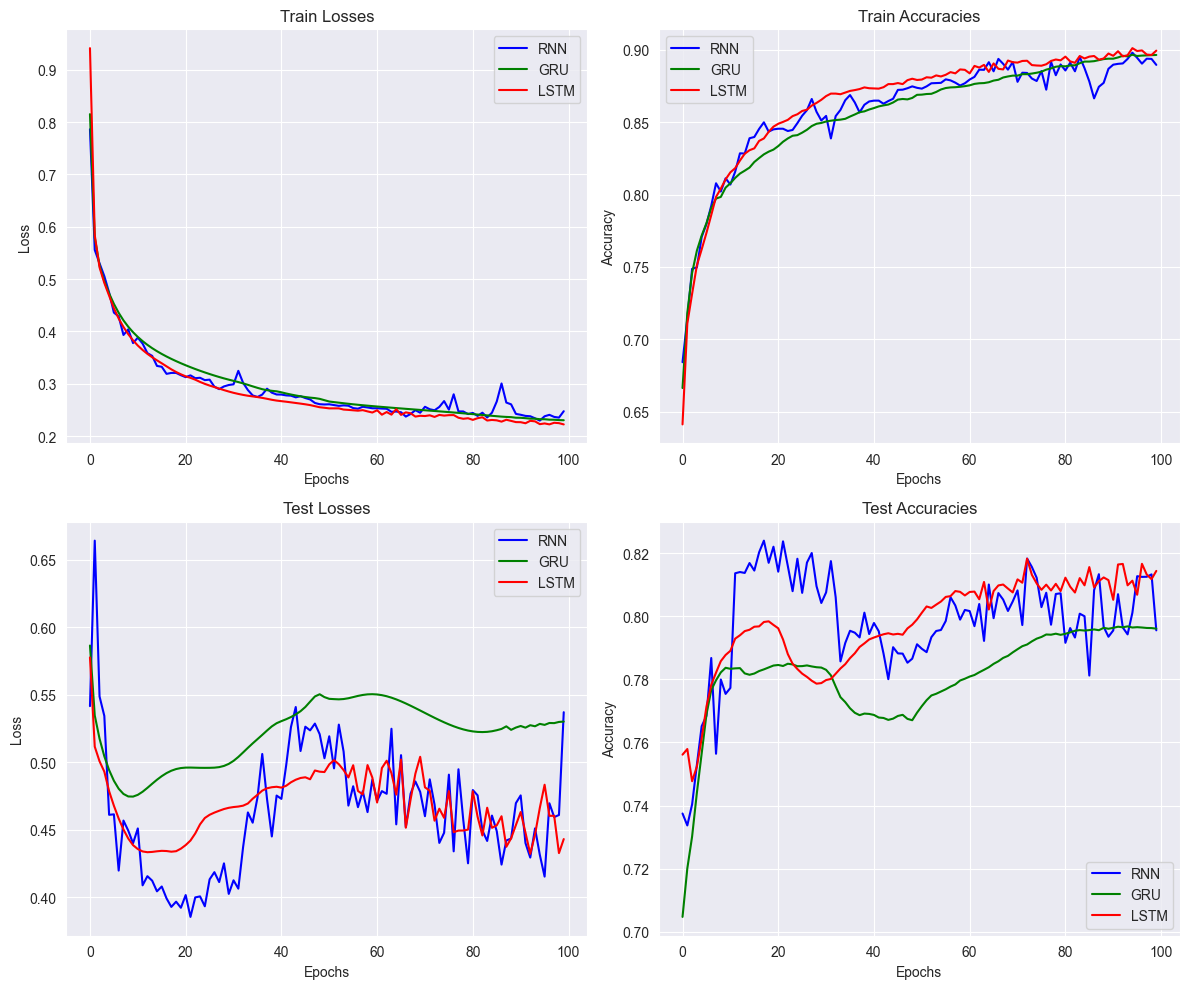

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(rnnResult.train_loss, label='RNN', color='blue')
axes[0, 0].plot(gruResult.train_loss, label='GRU', color='green')
axes[0, 0].plot(lstmResult.train_loss, label='LSTM', color='red')
axes[0, 0].set_title('Train Losses')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot train accuracies
axes[0, 1].plot(rnnResult.train_accuracy, label='RNN', color='blue')
axes[0, 1].plot(gruResult.train_accuracy, label='GRU', color='green')
axes[0, 1].plot(lstmResult.train_accuracy, label='LSTM', color='red')
axes[0, 1].set_title('Train Accuracies')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot test losses
axes[1, 0].plot(rnnResult.test_loss, label='RNN', color='blue')
axes[1, 0].plot(gruResult.test_loss, label='GRU', color='green')
axes[1, 0].plot(lstmResult.test_loss, label='LSTM', color='red')
axes[1, 0].set_title('Test Losses')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plot test accuracies
axes[1, 1].plot(rnnResult.test_accuracy, label='RNN', color='blue')
axes[1, 1].plot(gruResult.test_accuracy, label='GRU', color='green')
axes[1, 1].plot(lstmResult.test_accuracy, label='LSTM', color='red')
axes[1, 1].set_title('Test Accuracies')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()